In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path = "../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv"
required_columns = ['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa','u', 'v']
dtype_cast = {'wind_speed': float}


In [3]:
import os
import sys

# Get the absolute path of the directory containing the notebook (ensemble)
# Then get the parent directory's parent (which is the project root: wind-forecast-benchmark)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [4]:
from modules.preprocessing import *

INFO:modules.preprocessing:preprocessing module loaded (v1.0.0)


In [5]:
import pandas as pd

In [6]:
test_df = pd.read_csv(path)

In [7]:
test_df.columns

Index(['timestamp', 'temp_c', 'rel_humidity', 'wind_speed_kmh', 'pressure_kpa',
       'wind_dir_deg', 'timestamp_rounded', 'u', 'v', 'pressure_24h'],
      dtype='object')

In [8]:
df_basic_clean = load_and_basic_clean(path=path,
                                      required_columns=required_columns,
                                      sort_by='timestamp')

INFO:modules.preprocessing:Loaded CSV from '../../../data/cleaned/pincher_station_hourly_wind_cleaned.csv': 118474 rows, 10 columns
INFO:modules.preprocessing:Selected 7 required columns
INFO:modules.preprocessing:Sorted DataFrame by column 'timestamp'
INFO:modules.preprocessing:Data loading and cleaning completed successfully


In [9]:
df_basic_clean = df_basic_clean[0]

In [10]:
df_basic_clean.head(2)

,timestamp,temp_c,rel_humidity,wind_speed_kmh,pressure_kpa,u,v
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,5.785088,-6.894400
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,5.142301,-6.128356


In [11]:
clmns = {
    'timestamp':'datetime',
    'temp_c':'temperature',
    'rel_humidity':'humidity',
    'wind_speed_kmh':'wind_speed',
    'pressure_kpa':'pressure',
    
}
df_basic_clean.rename(columns=clmns, inplace=True)

In [12]:
df_basic_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118474 entries, 0 to 118473
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     118474 non-null  object 
 1   temperature  118474 non-null  float64
 2   humidity     118474 non-null  float64
 3   wind_speed   118474 non-null  float64
 4   pressure     118474 non-null  float64
 5   u            118474 non-null  float64
 6   v            118474 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.3+ MB


In [14]:
df_time_features = add_time_features(df_basic_clean)

In [15]:
df_time_features.head()

,datetime,temperature,humidity,wind_speed,pressure,u,v,hour,month,day_of_week,hour_sin,hour_cos
0,2011-06-27 14:00:00,7.9,85.0,9.0,88.14,5.785088,-6.894400,14,6,0,-0.500000,-8.660254e-01
1,2011-06-27 15:00:00,11.5,74.0,8.0,88.11,5.142301,-6.128356,15,6,0,-0.707107,-7.071068e-01
2,2011-06-27 16:00:00,15.4,61.0,5.0,88.04,3.213938,-3.830222,16,6,0,-0.866025,-5.000000e-01
3,2011-06-27 17:00:00,17.3,48.0,8.0,87.99,-5.142301,-6.128356,17,6,0,-0.965926,-2.588190e-01
4,2011-06-27 18:00:00,18.4,47.0,15.0,87.93,-12.990381,7.500000,18,6,0,-1.000000,-1.836970e-16


In [16]:
df_time_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118474 entries, 0 to 118473
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     118474 non-null  datetime64[ns]
 1   temperature  118474 non-null  float64       
 2   humidity     118474 non-null  float64       
 3   wind_speed   118474 non-null  float64       
 4   pressure     118474 non-null  float64       
 5   u            118474 non-null  float64       
 6   v            118474 non-null  float64       
 7   hour         118474 non-null  int32         
 8   month        118474 non-null  int32         
 9   day_of_week  118474 non-null  int32         
 10  hour_sin     118474 non-null  float64       
 11  hour_cos     118474 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int32(3)
memory usage: 9.5 MB


In [17]:
physical_featurs = ['temperature', 'pressure', 'u', 'v', 'wind_speed']

In [18]:
df_features = add_lag_and_rolling_features(df_time_features,target_cols=physical_featurs, lags=[1, 2, 3 ,24], dropna=True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Suppress logs
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [30]:
df = df_features.copy()

In [31]:

# ==========================================
# 1. FEATURE ENGINEERING (Specific to SVR)
# ==========================================
# We need to generate the specific features your snippet requested
# (Window 6 = 6 Hours, good for short-term volatility)

# 1. Create Lags (1, 2, 3) + U/V
LAGS = [1, 2, 3] 
cols_to_lag = ['wind_speed', 'u', 'v'] # Only lag key physics

def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

df_lags = make_lags(df, cols_to_lag, LAGS)
df_final = pd.concat([df, df_lags], axis=1)

# 2. Create the Specific Rolling Features from your snippet
# Window 6 implies a 6-hour trend
df_final['wind_speed_roll_mean_6'] = df_final['wind_speed'].rolling(window=6).mean()
df_final['wind_speed_roll_std_6'] = df_final['wind_speed'].rolling(window=6).std()
df_final['wind_speed_roll_max_6'] = df_final['wind_speed'].rolling(window=6).max()

# 3. Create Target
df_final['target_wind_speed'] = df_final['wind_speed'].shift(-1)
df_final.dropna(inplace=True)

# 4. DEFINE FEATS (Based on your manual selection)
FEATS = [
    # 1. The Physics (Current State)
    'u', 'v', 'pressure', 'temperature', 'humidity', 'wind_speed',
    
    # 2. Time Cyclicals
    'sin_h', 'cos_h', 
    
    # 3. Immediate Inertia (Lags)
    'wind_speed_L1', 'wind_speed_L2', 'u_L1', 'v_L1',
    
    # 4. Rolling Stats (Window 6)
    'wind_speed_roll_mean_6', 
    'wind_speed_roll_std_6',
    'wind_speed_roll_max_6' 
]

# Double check features exist
FEATS = [c for c in FEATS if c in df_final.columns]
print(f"Selected {len(FEATS)} features for SVR.")


Selected 13 features for SVR.


In [32]:

# ==========================================
# 2. OPTUNA OBJECTIVE FOR SVR
# ==========================================
def objective_svr(trial, X, y):
    # Hyperparameters to tune
    params = {
        'kernel': 'rbf', 
        # C: Regularization. High C = Strict (overfit risk), Low C = Smooth
        'C': trial.suggest_float('C', 0.1, 100.0, log=True),
        # Epsilon: The "tube" around the prediction line where errors are ignored
        'epsilon': trial.suggest_float('epsilon', 0.01, 1.0, log=True),
        # Gamma: Influence of a single training point
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    # Cross-Validation
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # PIPELINE: SCALING + SVR
        # We fit the scaler ONLY on the training fold to avoid data leakage
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(**params))
        ])
        
        model.fit(X_train_cv, y_train_cv)
        preds = model.predict(X_val_cv)
        
        mae = mean_absolute_error(y_val_cv, preds)
        scores.append(mae)

    return np.mean(scores)


In [33]:

# ==========================================
# 3. ROLLING FORECAST LOOP
# ==========================================
# Config
RETRAIN_INTERVAL = 168      
TUNING_WINDOW_HOURS = 2160  
SLIDING_WINDOW_SIZE = 4300  
N_TRIALS = 15 # Keep low as SVR is slower than XGB

# Split (Same as XGBoost run)
train_end = len(df_final) - 720 

print("Starting SVR with Bayesian Optimization (1-Hour Interval)...")

preds_svr = []
model_svr = None
svr_best_params = {}

for t in range(train_end, len(df_final)):

    # --- PERIODIC RETRAINING ---
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- [Step {t}] Retuning SVR ---")
        
        # [A] BAYESIAN TUNING
        tune_start = max(0, t - TUNING_WINDOW_HOURS)
        X_tune = df_final.iloc[tune_start:t][FEATS].values
        y_tune = df_final.iloc[tune_start:t]['target_wind_speed'].values
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_svr(trial, X_tune, y_tune), n_trials=N_TRIALS)
        
        svr_best_params = study.best_params
        print(f"Best Params: {svr_best_params}")
        
        # [B] FINAL TRAINING (Sliding Window)
        train_start = max(0, t - SLIDING_WINDOW_SIZE)
        X_train = df_final.iloc[train_start:t][FEATS].values
        y_train = df_final.iloc[train_start:t]['target_wind_speed'].values
        
        # Build Final Pipeline
        model_svr = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(kernel='rbf', **svr_best_params))
        ])
        model_svr.fit(X_train, y_train)

    # --- PREDICTION ---
    if model_svr is None:
        preds_svr.append(np.nan)
        continue

    x_next = df_final.iloc[[t]][FEATS].values
    preds_svr.append(model_svr.predict(x_next)[0])


Starting SVR with Bayesian Optimization (1-Hour Interval)...

--- [Step 117724] Retuning SVR ---
Best Params: {'C': 5.949173327610738, 'epsilon': 0.13443594325926395, 'gamma': 'auto'}

--- [Step 117892] Retuning SVR ---
Best Params: {'C': 7.82894393823287, 'epsilon': 0.011572776831320783, 'gamma': 'scale'}

--- [Step 118060] Retuning SVR ---
Best Params: {'C': 6.202460287108848, 'epsilon': 0.4689611174406593, 'gamma': 'scale'}

--- [Step 118228] Retuning SVR ---
Best Params: {'C': 6.637741265438855, 'epsilon': 0.9436457708764877, 'gamma': 'scale'}

--- [Step 118396] Retuning SVR ---
Best Params: {'C': 14.000403556094003, 'epsilon': 0.42294138639163226, 'gamma': 'auto'}


In [34]:

# ==========================================
# 4. EVALUATION & SAVING
# ==========================================
test_df_svr = df_final.iloc[train_end:].copy()
test_df_svr['pred_svr'] = preds_svr
test_df_svr.dropna(subset=['pred_svr'], inplace=True)

mae = mean_absolute_error(test_df_svr['target_wind_speed'], test_df_svr['pred_svr'])
rmse = np.sqrt(mean_squared_error(test_df_svr['target_wind_speed'], test_df_svr['pred_svr']))

print("\n" + "="*30)
print(f"FINAL SVR RESULTS")
print(f"MAE:  {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print("="*30)

# Save Results for the Hybrid Step
results_svr_df = test_df_svr[['target_wind_speed', 'pred_svr']].copy()
results_svr_df.to_csv('svr_results_1h.csv', index=True)
print("✅ SVR Predictions saved to 'svr_results_1h.csv'")


FINAL SVR RESULTS
MAE:  6.47582
RMSE: 9.04382
✅ SVR Predictions saved to 'svr_results_1h.csv'


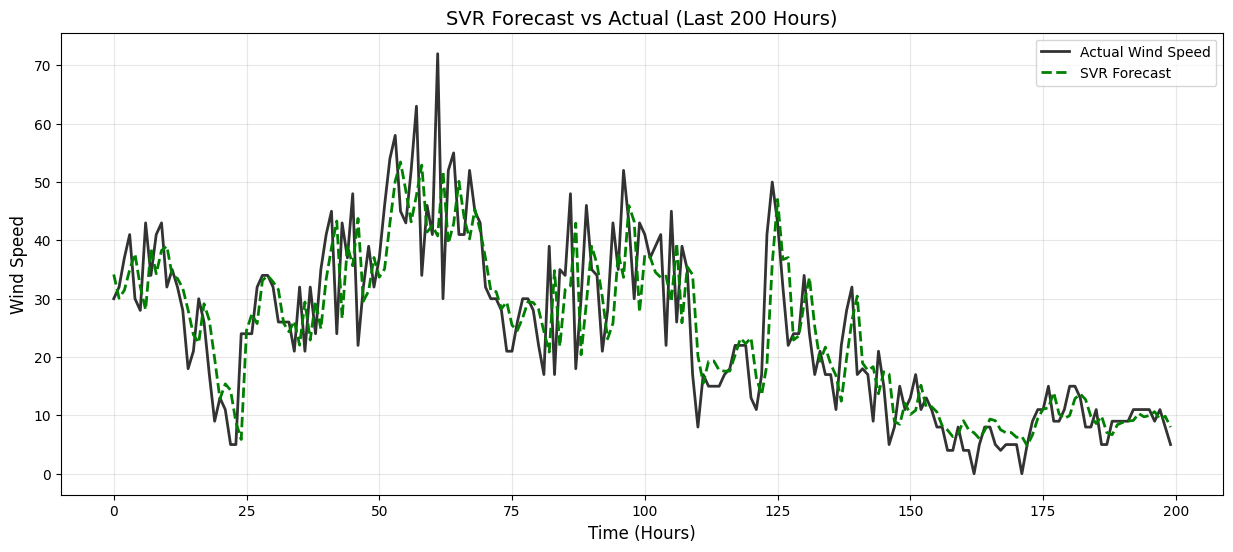

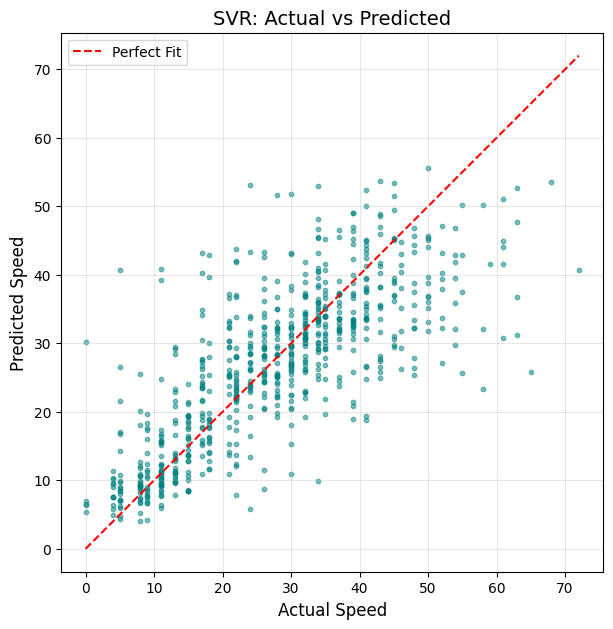

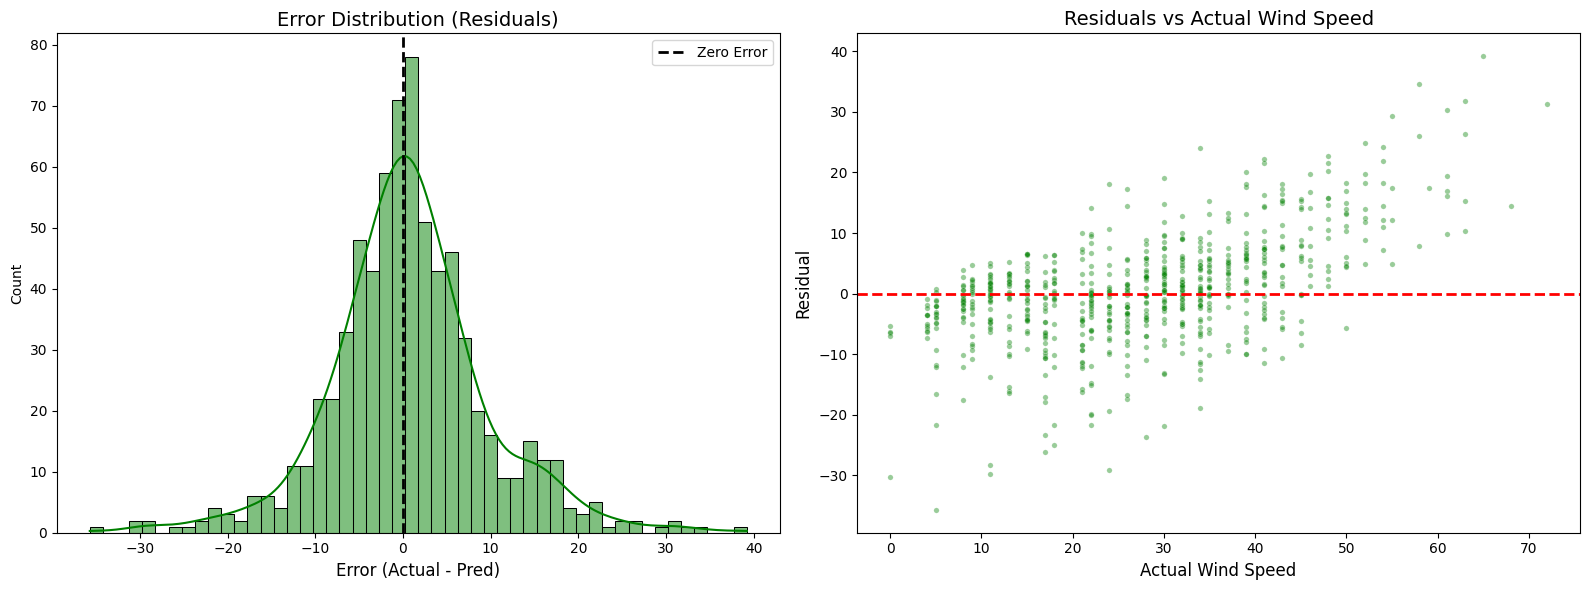

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Residuals
test_df_svr['residuals'] = test_df_svr['target_wind_speed'] - test_df_svr['pred_svr']

# ==========================================
# 1. Forecast vs Actual (Zoomed In)
# ==========================================
subset = 200 
actuals = test_df_svr['target_wind_speed'].tail(subset).values
preds = test_df_svr['pred_svr'].tail(subset).values

plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Actual Wind Speed', color='black', linewidth=2, alpha=0.8)
plt.plot(preds, label='SVR Forecast', color='green', linestyle='--', linewidth=2)

plt.title(f"SVR Forecast vs Actual (Last {subset} Hours)", fontsize=14)
plt.xlabel("Time (Hours)", fontsize=12)
plt.ylabel("Wind Speed", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 2. Regression Scatter Plot
# ==========================================
plt.figure(figsize=(7, 7))
plt.scatter(test_df_svr['target_wind_speed'], test_df_svr['pred_svr'], 
            alpha=0.5, s=10, color='teal')

# 1:1 Perfect Prediction Line
min_val = min(test_df_svr['target_wind_speed'].min(), test_df_svr['pred_svr'].min())
max_val = max(test_df_svr['target_wind_speed'].max(), test_df_svr['pred_svr'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')

plt.title("SVR: Actual vs Predicted", fontsize=14)
plt.xlabel("Actual Speed", fontsize=12)
plt.ylabel("Predicted Speed", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# ==========================================
# 3. Residual Distribution & Bias Check
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(test_df_svr['residuals'], kde=True, bins=50, color='green', ax=ax[0])
ax[0].axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Error')
ax[0].set_title("Error Distribution (Residuals)", fontsize=14)
ax[0].set_xlabel("Error (Actual - Pred)", fontsize=12)
ax[0].legend()

# Residuals vs Actuals (Heteroscedasticity Check)
sns.scatterplot(x=test_df_svr['target_wind_speed'], y=test_df_svr['residuals'], 
                color='green', alpha=0.4, s=15, ax=ax[1])
ax[1].axhline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_title("Residuals vs Actual Wind Speed", fontsize=14)
ax[1].set_xlabel("Actual Wind Speed", fontsize=12)
ax[1].set_ylabel("Residual", fontsize=12)

plt.tight_layout()
plt.show()